# Recommendation Movie
![film](./film.jpg)
membuat model rekomendasi untuk memberikan saran kepada pengguna. dataset yang digunakan berasal dari kaggle, berikut adalah linknya:
https://www.kaggle.com/datasets/stefanoleone992/filmtv-movies-dataset?select=filmtv_movies.csv

# Import Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import string
import numpy as np

# Upload cvs

In [4]:
# Load the dataset
df = pd.read_csv('filmtv_movies.csv')

# Display the first few rows of the dataset
df.head(5)

,filmtv_id,title,year,genre,duration,country,directors,actors,avg_vote,critics_vote,public_vote,total_votes,description,notes,humor,rhythm,effort,tension,erotism
0,2,Bugs Bunny's Third Movie: 1001 Rabbit Tales,1982,Animation,76,United States,"David Detiege, Art Davis, Bill Perez",NaN,7.7,8.00,7.0,22,"With two protruding front teeth, a slightly sl...","These are many small independent stories, whic...",3,3,0,0,0
1,3,18 anni tra una settimana,1991,Drama,98,Italy,Luigi Perelli,"Kim Rossi Stuart, Simona Cavallari, Ennio Fant...",6.5,6.00,7.0,4,"Samantha, not yet eighteen, leaves the comfort...","Luigi Perelli, the director of the ""Piovra"", o...",0,2,0,2,0
2,17,Ride a Wild Pony,1976,Romantic,91,United States,Don Chaffey,"Michael Craig, John Meillon, Eva Griffith, Gra...",5.7,6.00,5.0,10,"In the Australia of the pioneers, a boy and a ...","""Ecological"" story with a happy ending, not wi...",1,2,1,0,0
3,18,Diner,1982,Comedy,95,United States,Barry Levinson,"Mickey Rourke, Steve Guttenberg, Ellen Barkin,...",7.0,8.00,6.0,18,Five boys from Baltimore have a habit of meeti...,A cast of will be famous for Levinson's direct...,2,2,0,1,2
4,20,A che servono questi quattrini?,1942,Comedy,85,Italy,Esodo Pratelli,"Eduardo De Filippo, Peppino De Filippo, Clelia...",5.9,5.33,7.0,15,"With a stratagem, the penniless and somewhat p...",Taken from the play by Armando Curcio that the...,3,1,1,0,0


In [5]:
# cek baris dan kolom
df.shape

(41399, 19)

In [6]:
#cek info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41399 entries, 0 to 41398
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   filmtv_id     41399 non-null  int64  
 1   title         41399 non-null  object 
 2   year          41399 non-null  int64  
 3   genre         41304 non-null  object 
 4   duration      41399 non-null  int64  
 5   country       41389 non-null  object 
 6   directors     41365 non-null  object 
 7   actors        39272 non-null  object 
 8   avg_vote      41399 non-null  float64
 9   critics_vote  36703 non-null  float64
 10  public_vote   41205 non-null  float64
 11  total_votes   41399 non-null  int64  
 12  description   39857 non-null  object 
 13  notes         18797 non-null  object 
 14  humor         41399 non-null  int64  
 15  rhythm        41399 non-null  int64  
 16  effort        41399 non-null  int64  
 17  tension       41399 non-null  int64  
 18  erotism       41399 non-nu

terdapat 19 kolom dengan detail informasi :
1. 9 kolom dengan tipe data int64, kolom tersebut adalah:
    - `filmtv_id`: key feature dari film tv yang diambil dari website
    - `year`: tahun muncul film
    - `duration`: lama waktu durasi film dalam menit
    - `total_votes`: jumlah vote dari critics dan public
    - `humor`: skor untuk movie humor dari filmtv
    - `rhythm`: skor untuk ritme movie dari filmtv
    - `effort`: skor untuk effort movie dari filmtv
    - `tension`: skor untuk tensi movie dari filmtv
    - `erotism`: skor untuk nilai erotis dalam movie dari filmtv
2. 7 kolom dengan tipe data object, kolom tersebut adalah:
    - `title`: judul original untuk movie
    - `genre`: genre dari movie
    - `country`: negara tempat memproduksi movie
    - `directors`: nama dari direktor movie tersebut
    - `actors`: nama dari aktor movie
    - `description`: deskripsi dari movie
    - `notes`: info tambahan unutk movie
3. 3 kolom dengan tipe data float64, kolom tersebut adalah:
    - `avg_vote`: nilai rata-rata rating dari critics dan public
    - `critics_vote`: nilai rata-rata dari critics
    - `public_vote`: nilai rata-rata vote dari public

# Exploratory Data Analysis
Pengambilan beberapa feature. kita akan mengambil beberapa feature saja untuk membangun model sistem rekomendasi. feature yang akan kita gunakan adalah `title`, `avg_vote`, `filmtv_id`, `genre`, dan, `directors`. feature tersebut digunakan untuk membangun model *content based filtering* dan *collaborative filtering*. untuk detail informasi adalah:
1. *Content based filtering* menggunakna feature:
    - title
    - genres
2. *Collaborative filtering* menggunakan feature:
    - title
    - avg_vote

visualisasi dari avg_vote

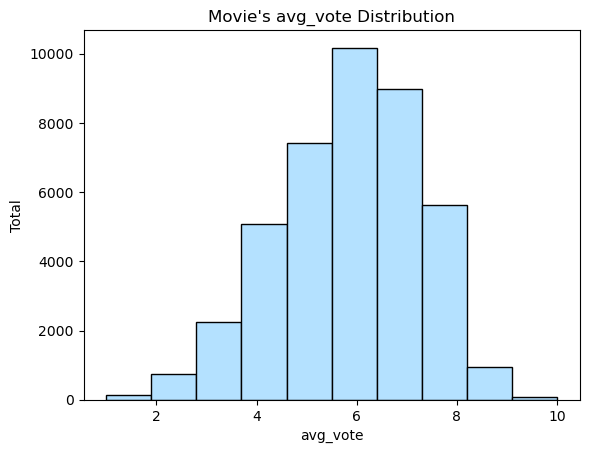

In [7]:
#cek missing value
plt.hist(df.avg_vote, color='#B4E1FF', edgecolor='black')
plt.ylabel('Total')
plt.xlabel('avg_vote')
plt.title("Movie's avg_vote Distribution")
plt.show()

mengecek banyak film dalam genre

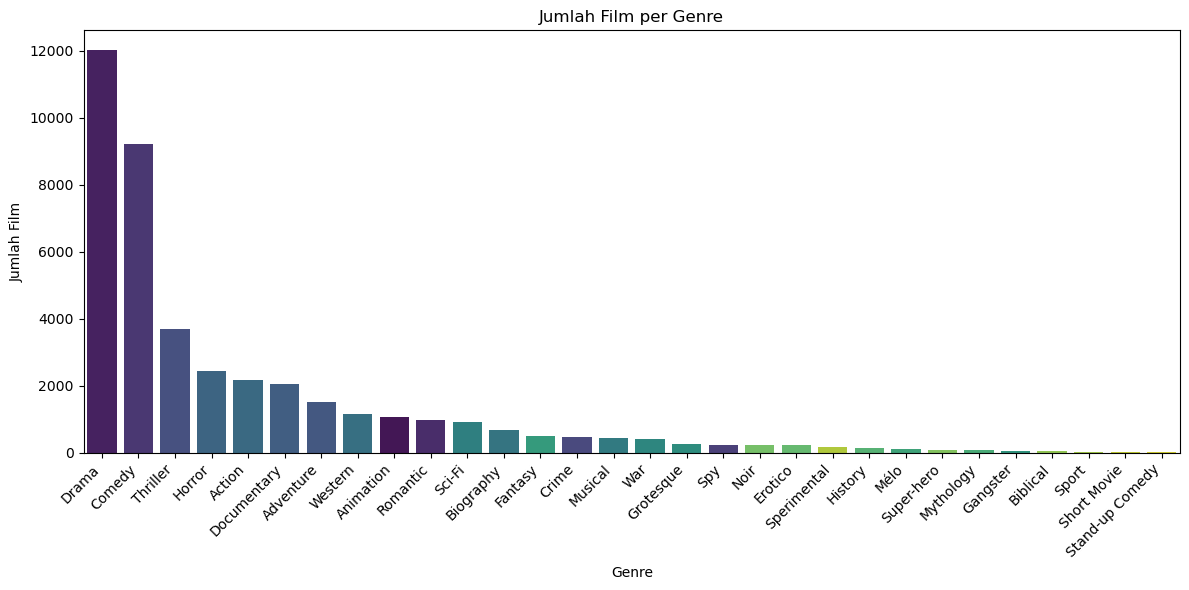

In [8]:
# Visualisasi jumlah film pada setiap genre
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='genre', hue='genre', order=df['genre'].value_counts().index, palette='viridis', legend=False)
plt.xticks(rotation=45, ha='right')
plt.title('Jumlah Film per Genre')
plt.xlabel('Genre')
plt.ylabel('Jumlah Film')
plt.tight_layout()
plt.show()

mengecek informasi detail tiap feature

In [9]:
# print describe df
df.describe().T

,count,mean,std,min,25%,50%,75%,max
filmtv_id,41399.0,57746.410179,59962.095730,2.0,15857.00,36266.0,70935.0,232920.0
year,41399.0,1993.505302,23.685612,1897.0,1976.00,2001.0,2013.0,2023.0
duration,41399.0,100.537163,27.260962,41.0,90.00,96.0,107.0,1525.0
avg_vote,41399.0,5.801522,1.403861,1.0,4.80,5.9,6.9,10.0
critics_vote,36703.0,5.796077,1.593062,1.0,4.67,6.0,7.0,10.0
public_vote,41205.0,5.924135,1.480112,1.0,5.00,6.0,7.0,10.0
total_votes,41399.0,36.986763,69.386853,1.0,5.00,12.0,36.0,1082.0
humor,41399.0,0.577381,0.899402,0.0,0.00,0.0,1.0,5.0
rhythm,41399.0,1.345347,1.154829,0.0,0.00,2.0,2.0,5.0
effort,41399.0,0.684847,1.112334,0.0,0.00,0.0,1.0,5.0


Fungsi `describe()` memberikan informasi statistik pada masing-masing kolom, antara lain:

- `Count` adalah jumlah sampel pada data.
- `Mean` adalah nilai rata-rata.
- `Std` adalah standar deviasi.
- `Min` yaitu nilai minimum setiap kolom.
- `25%` adalah kuartil pertama. Kuartil adalah nilai yang menandai batas interval dalam empat bagian sebaran yang sama.
- `50%` adalah kuartil kedua, atau biasa juga disebut median (nilai tengah). - 75% adalah kuartil ketiga.
- `Max` adalah nilai maksimum.

pengecekan jumlah nilai duplikat

In [10]:
# cek duplikat
df.duplicated().sum()

0

tidak ada data yang duplikat

selanjutnya, mengecek apakah ada data kosong

In [11]:
# cek nilai kosong
df.isnull().sum()

filmtv_id           0
title               0
year                0
genre              95
duration            0
country            10
directors          34
actors           2127
avg_vote            0
critics_vote     4696
public_vote       194
total_votes         0
description      1542
notes           22602
humor               0
rhythm              0
effort              0
tension             0
erotism             0
dtype: int64

ternyata terdapat banyak nilai null pada dataframe

# Data Preprocessing

mengambil feature yang digunakan saja

In [12]:
# mengambil beberapa feature saja
df_set = df[['title', 'avg_vote', 'filmtv_id', 'genre', 'directors','description']].copy()

mengecek feature apa yang kosong

In [13]:
# cek duplikat pada df_set
df_set.isnull().sum()

title             0
avg_vote          0
filmtv_id         0
genre            95
directors        34
description    1542
dtype: int64

menghapus nilai yang hilang

In [14]:
# drop missing values
df_set.dropna(inplace=True)
print(df_set.shape)

(39742, 6)


mengecek ulang data

In [15]:
# cek total missing values after dropping
df_set.isnull().sum()

title          0
avg_vote       0
filmtv_id      0
genre          0
directors      0
description    0
dtype: int64

mengecek informasi dari genre

In [16]:
# cek genre unik
df_set.genre.unique()

array(['Animation', 'Drama', 'Romantic', 'Comedy', 'Spy', 'Crime',
       'Thriller', 'Adventure', 'Documentary', 'Horror', 'Action',
       'Western', 'Biography', 'Musical', 'Sci-Fi', 'War', 'Grotesque',
       'Gangster', 'Fantasy', 'Mélo', 'Mythology', 'History', 'Erotico',
       'Noir', 'Super-hero', 'Biblical', 'Sport', 'Sperimental',
       'Short Movie', 'Stand-up Comedy'], dtype=object)

mengecek informasi dari directors

In [17]:
# cek directors unik
df_set.directors.unique().tolist()[:10]

['David Detiege, Art Davis, Bill Perez',
 'Luigi Perelli',
 'Don Chaffey',
 'Barry Levinson',
 'Esodo Pratelli',
 'Gianfranco Baldanello, Menahem Golan',
 'Elio Petri',
 'John Frankenheimer',
 'Ray Morrison (Angelo Dorigo)',
 'James Foley']

pada beberapa baris terdapat nilai double pada directors

In [18]:
# Menghitung jumlah baris dengan lebih dari satu director (ditandai dengan koma)
multi_director_count = df_set['directors'].str.contains(',', na=False).sum()
print(f"Jumlah baris dengan lebih dari satu director: {multi_director_count}")

Jumlah baris dengan lebih dari satu director: 2111


In [19]:
# Menghapus baris dengan lebih dari satu director (ada koma di kolom 'directors')
df_set = df_set[~df_set['directors'].str.contains(',', na=False)]
print(df_set.shape)

(37631, 6)


mengambil feature yang digunakna untuk membuat model content based filtering

In [22]:
# Membuat DataFrame baru untuk Content-Based Filtering (CBF)
df_cbf = pd.DataFrame({
    'filmtv_id': df_set['filmtv_id'],
    'title': df_set['title'],
    'genre': df_set['genre'],
    'description': df_set['description'].apply(lambda x: x.lower().strip())
})
# Menampilkan DataFrame CBF
df_cbf.head(5)

,filmtv_id,title,genre,description
1,3,18 anni tra una settimana,Drama,"samantha, not yet eighteen, leaves the comfort..."
2,17,Ride a Wild Pony,Romantic,"in the australia of the pioneers, a boy and a ..."
3,18,Diner,Comedy,five boys from baltimore have a habit of meeti...
4,20,A che servono questi quattrini?,Comedy,"with a stratagem, the penniless and somewhat p..."
6,22,A ciascuno il suo,Drama,investigations into two murders committed in a...


# Model Development dengan Content Based Filtering

menggunakan TF-IDF Vectorizer menggunakan fungsi tfidfvectorizer() dari library sklearn.

In [23]:
# Inisialisasi TfidfVectorizer
tf = TfidfVectorizer()
 
# Melakukan perhitungan idf pada data cuisine
tf.fit(df_cbf['genre']) 
 
# Mapping array dari fitur index integer ke fitur nama
tf.get_feature_names_out()

array(['action', 'adventure', 'animation', 'biblical', 'biography',
       'comedy', 'crime', 'documentary', 'drama', 'erotico', 'fantasy',
       'fi', 'gangster', 'grotesque', 'hero', 'history', 'horror',
       'movie', 'musical', 'mythology', 'mélo', 'noir', 'romantic', 'sci',
       'short', 'sperimental', 'sport', 'spy', 'stand', 'super',
       'thriller', 'up', 'war', 'western'], dtype=object)

lakukan fit dan transformasi ke dalam bentuk matriks.

In [24]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = tf.fit_transform(df_cbf['genre'])
 
# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(37631, 34)

matriks yang kita miliki berukuran (95, 22). Nilai 95 merupakan ukuran data dan 22 merupakan matrik kategori masakan. 

Untuk menghasilkan vektor tf-idf dalam bentuk matriks, kita menggunakan fungsi todense().

In [25]:
# Mengubah vektor tf-idf dalam bentuk matriks dengan fungsi todense()
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

lihat matriks tf-idf untuk beberapa resto (resto_name) dan kategori masakan (cuisine).

In [26]:
# Menampilkan DataFrame dengan fitur tf-idf
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names_out(),
    index=df_cbf.title
).sample(28, axis=1).sample(10, axis=0)

,stand,thriller,fi,biblical,super,spy,movie,up,hero,history,...,mythology,short,comedy,gangster,sci,war,crime,sport,drama,erotico
title,,,,,,,,,,,,,,,,,,,,,
Unbroken,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Gifted,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Savva. Serdtse voina,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Princess,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Past Lies,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
For Queen and Country,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Beetlejuice,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Una pallottola nel cuore: Il passato che ritorna,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A casa tutti bene,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


lakukan fit dan transformasi ke dalam bentuk matriks.

In [27]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 1.]])

In [28]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama resto
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_cbf['title'], columns=df_cbf['title'])
print('Shape:', cosine_sim_df.shape)
 
# Melihat similarity matrix pada setiap resto
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (37631, 37631)


title,Die 1000 Augen des dr. Mabuse,The Little Shop of Horrors,The Black Balloon,Crocodile Dundee II,Love & Peace
title,,,,,
La guerra di Troia,0.0,0.0,0.0,0.0,0.0
Oz: The Great and Powerful,0.0,0.0,0.0,0.0,0.0
Music Box,0.0,0.0,1.0,0.0,1.0
Pieta,0.0,0.0,1.0,0.0,1.0
Deep Red,1.0,0.0,0.0,0.0,0.0
Fughe e approdi,0.0,0.0,0.0,0.0,0.0
Ivanovo devstvo,0.0,0.0,1.0,0.0,1.0
I Spit on Your Grave,0.0,0.0,0.0,0.0,0.0
La doppia vita di Natalia Blum,1.0,0.0,0.0,0.0,0.0


In [29]:
def title_recommendations(title, similarity_data=cosine_sim_df, items=df_cbf[['title', 'genre','description']], k=5):
    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan    
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(-1, -k, -1))
    
    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(title, errors='ignore')
 
    return pd.DataFrame(closest).merge(items).head(k)

In [30]:
df_cbf[df_cbf.title.eq('The Adventures of Don Juan')]

,filmtv_id,title,genre,description
470,735,The Adventures of Don Juan,Adventure,"""don giovanni, a spanish gentleman, must leave..."


In [31]:
# Mendapatkan rekomendasi restoran yang mirip dengan KFC
title_recommendations('The Adventures of Don Juan')

,title,genre,description
0,The Amazons,Adventure,"antiope, by eliminating one by one all the can..."
1,Clash of the Titans,Adventure,perseus was born from one of the many terrestr...
2,A Dog's Way Home,Adventure,a dog embarks on a solo journey of more than 4...
3,I Normanni,Adventure,"during the ninth century, some norman tribes d..."
4,The Black Shield of Falworth,Adventure,having escaped the extermination of the noble ...


Model COntent Based Filtering dapat merekomendasikan top 5 movie yang mirip dengan Pay or Die

# Model Development dengan Collaborative Filtering

pahami terlebih dahulu data rating yang kita miliki. Ingatlah saat Anda melakukan load data di awal dan membaca file rating_final.csv. Saat itu, Anda membuat variabel rating dan menetapkan data pada variabel tersebut.

Anda perlu melakukan persiapan data untuk menyandikan (encode) fitur ‘user’ dan ‘placeID’ ke dalam indeks integer.

In [33]:
# copy dataframe untuk cross validation
df_cv = df_set.copy()
df_cv.head(5)

,title,avg_vote,filmtv_id,genre,directors,description
1,18 anni tra una settimana,6.5,3,Drama,Luigi Perelli,"Samantha, not yet eighteen, leaves the comfort..."
2,Ride a Wild Pony,5.7,17,Romantic,Don Chaffey,"In the Australia of the pioneers, a boy and a ..."
3,Diner,7.0,18,Comedy,Barry Levinson,Five boys from Baltimore have a habit of meeti...
4,A che servono questi quattrini?,5.9,20,Comedy,Esodo Pratelli,"With a stratagem, the penniless and somewhat p..."
6,A ciascuno il suo,7.6,22,Drama,Elio Petri,Investigations into two murders committed in a...


In [ ]:
# Membuat list huruf a-z
letters = list(string.ascii_lowercase)
n_letters = len(letters)
n_rows = len(df_cv)

# Hitung jumlah baris per huruf (porsi merata)
rows_per_letter = n_rows // n_letters
remainder = n_rows % n_letters

# Buat list huruf untuk semua baris
letter_list = []
for i, letter in enumerate(letters):
    count = rows_per_letter + (1 if i < remainder else 0)
    letter_list.extend([letter] * count)

# Acak urutan huruf
np.random.shuffle(letter_list)

# Tambahkan ke dataframe sebagai kolom baru
df_cv['user'] = letter_list
df_cv.head()

,title,avg_vote,filmtv_id,genre,directors,description,user
1,18 anni tra una settimana,6.5,3,Drama,Luigi Perelli,"Samantha, not yet eighteen, leaves the comfort...",g
2,Ride a Wild Pony,5.7,17,Romantic,Don Chaffey,"In the Australia of the pioneers, a boy and a ...",i
3,Diner,7.0,18,Comedy,Barry Levinson,Five boys from Baltimore have a habit of meeti...,s
4,A che servono questi quattrini?,5.9,20,Comedy,Esodo Pratelli,"With a stratagem, the penniless and somewhat p...",r
6,A ciascuno il suo,7.6,22,Drama,Elio Petri,Investigations into two murders committed in a...,f


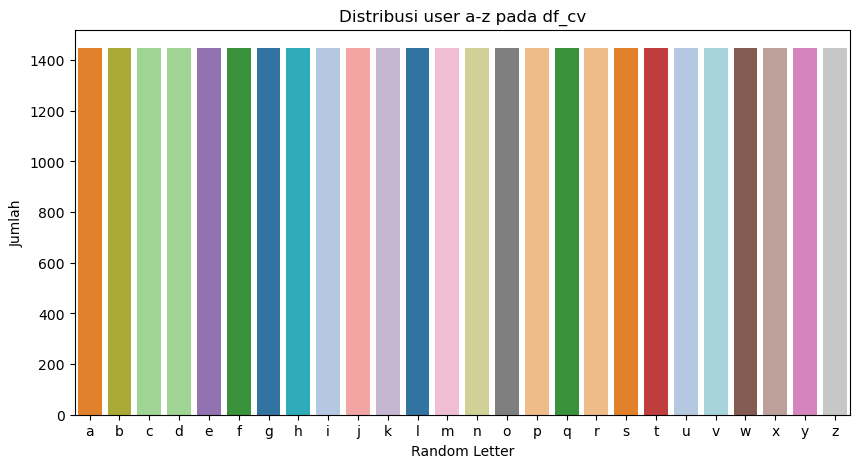

In [35]:
# Visualisasi distribusi user a-z pada df_cv
plt.figure(figsize=(10,5))
sns.countplot(data=df_cv, x='user', hue='user', order=sorted(df_cv['user'].unique()), palette='tab20', legend=False)
plt.title('Distribusi user a-z pada df_cv')
plt.xlabel('Random Letter')
plt.ylabel('Jumlah')
plt.show()

persiapan untuk menyandikan dalam indeks integer

In [36]:
# Membuat salinan dari df_cv untuk cross validation
df_cv_first = df_cv.copy()

# Mengubah filmtv_id menjadi list tanpa nilai yang sama
user_id = df_cv['user'].unique().tolist()
print('list user: ', user_id)
 
# Melakukan encoding filmtv_id
user_to_user_encoded = {x: i for i, x in enumerate(user_id)}
print('encoded filmtv_id : ', user_to_user_encoded)
 
# Melakukan proses encoding angka ke ke filmtv_id
user_encoded_to_user = {i: x for i, x in enumerate(user_id)}
print('encoded angka ke filmtv_id: ', user_encoded_to_user)

list user:  ['g', 'i', 's', 'r', 'f', 'd', 't', 'j', 'e', 'k', 'w', 'x', 'y', 'm', 'o', 'z', 'b', 'n', 'h', 'v', 'l', 'u', 'a', 'p', 'q', 'c']
encoded filmtv_id :  {'g': 0, 'i': 1, 's': 2, 'r': 3, 'f': 4, 'd': 5, 't': 6, 'j': 7, 'e': 8, 'k': 9, 'w': 10, 'x': 11, 'y': 12, 'm': 13, 'o': 14, 'z': 15, 'b': 16, 'n': 17, 'h': 18, 'v': 19, 'l': 20, 'u': 21, 'a': 22, 'p': 23, 'q': 24, 'c': 25}
encoded angka ke filmtv_id:  {0: 'g', 1: 'i', 2: 's', 3: 'r', 4: 'f', 5: 'd', 6: 't', 7: 'j', 8: 'e', 9: 'k', 10: 'w', 11: 'x', 12: 'y', 13: 'm', 14: 'o', 15: 'z', 16: 'b', 17: 'n', 18: 'h', 19: 'v', 20: 'l', 21: 'u', 22: 'a', 23: 'p', 24: 'q', 25: 'c'}


lakukan juga untuk title

In [37]:
# Mengubah title menjadi list tanpa nilai yang sama
title_ids = df_cv['title'].unique().tolist()
print('list title: ', title_ids)
 
# Melakukan encoding title
title_to_title_encoded = {x: i for i, x in enumerate(title_ids)}
print('encoded title : ', title_to_title_encoded)
 
# Melakukan proses encoding angka ke ke title
title_encoded_to_title = {i: x for i, x in enumerate(title_ids)}
print('encoded angka ke title: ', title_encoded_to_title)

list title:  ['18 anni tra una settimana', 'Ride a Wild Pony', 'Diner', 'A che servono questi quattrini?', 'A ciascuno il suo', 'Dead-Bang', 'A... come assassino', 'At Close Range', 'A Ghentar si muore facile', 'Sleeping with the Enemy', 'In Bed With Madonna', 'Bowery at Midnight', 'A mezzanotte va la ronda del piacere', 'Mr. Majestyk', 'Warning Sign', 'About Last Night', 'Fail-Safe', 'Some Like It Hot', 'A qualsiasi prezzo', "Johnny O'Clock", 'Back to School', 'Driving Miss Daisy', 'Enid Is Sleeping', 'The Appaloosa', '...a tutte le auto della polizia...', "You'll Like My Mother", 'Abbasso la miseria!', 'Abbasso la ricchezza!', 'Can You Feel Me Dancing?', 'Charlie Muffin', 'Abbronzatissimi', 'The Deep', 'Abe Lincoln in Illinois', 'Absolute Beginners', 'The Abyss', 'Acapulco, prima spiaggia... a sinistra', 'Accadde al penitenziario', 'It Happened Tomorrow', 'Made in Heaven', 'September Affair', 'It Happened One Night', 'Accattone', 'Arrêt sur image', 'Achtung! Banditi!', 'Water', 'Acqu

mengecek isi dari df_cv

In [38]:
# tampilkan df_cv dengan kolom user dan title yang sudah di-encode
df_cv.head(5)

,title,avg_vote,filmtv_id,genre,directors,description,user
1,18 anni tra una settimana,6.5,3,Drama,Luigi Perelli,"Samantha, not yet eighteen, leaves the comfort...",g
2,Ride a Wild Pony,5.7,17,Romantic,Don Chaffey,"In the Australia of the pioneers, a boy and a ...",i
3,Diner,7.0,18,Comedy,Barry Levinson,Five boys from Baltimore have a habit of meeti...,s
4,A che servono questi quattrini?,5.9,20,Comedy,Esodo Pratelli,"With a stratagem, the penniless and somewhat p...",r
6,A ciascuno il suo,7.6,22,Drama,Elio Petri,Investigations into two murders committed in a...,f


petakan filmtv_id dan title ke dataframe yang berkaitan

In [39]:
# Mapping filmtv_id ke dataframe user
df_cv['user'] = df_cv['user'].map(user_to_user_encoded)
 
# Mapping title ke dataframe resto
df_cv['title'] = df_cv['title'].map(title_to_title_encoded)

acak datanya terlebih dahulu agar distribusinya menjadi random

In [40]:
# Mengacak dataset
df_cv = df_cv.sample(frac=1, random_state=42)
# tampilkan 5 baris pertama dari df_cv
df_cv.head(5)

,title,avg_vote,filmtv_id,genre,directors,description,user
37671,32837,7.4,170465,Musical,Bruno Dumont,Year 1429. The Hundred Years War rages. Jeanne...,19
20654,17959,7.3,36113,Western,William Witney,"Arizona, 1879. The young cavalry officer Jeff ...",2
19051,3200,7.3,31331,Comedy,Edouard Molinaro,An entrepreneur gets into trouble when the ass...,1
923,894,6.2,1391,Drama,Paul Czinner,The marriage between the German princess Cathe...,2
30355,26491,3.0,66721,Drama,Stéphane Giusti,Ten years have passed since the end of the Tro...,3


mengecek informasi data jumlah, nilai min, dan nilai max

In [41]:
# medapatkan jumlah filmtv_id
jumlah_user = len(user_to_user_encoded)
print('Jumlah filmtv_id: ', jumlah_user)

# mendapatkan jumlah title
jumlah_title = len(title_to_title_encoded)
print('Jumlah title: ', jumlah_title)

# nilai minimum vote
min_vote = df_cv['avg_vote'].min()

# nilai maksimum vote
max_vote = df_cv['avg_vote'].max()

# menampilkan informasi jumlah filmtv_id, jumlah title, nilai minimum vote, dan nilai maksimum vote
print('banyak filmtv_id: {}, banyak title: {}, nilai minimum vote: {}, nilai maksimum vote: {}'.format(
      jumlah_user, jumlah_title, min_vote, max_vote
))

Jumlah filmtv_id:  26
Jumlah title:  36052
banyak filmtv_id: 26, banyak title: 36052, nilai minimum vote: 1.0, nilai maksimum vote: 10.0


bagi data train dan validasi dengan komposisi 90:10. Namun sebelumnya, kita perlu memetakan (mapping) menjadi satu value terlebih dahulu. Lalu, buatlah rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training. 

In [42]:
# Membuat variabel x untuk mencocokkan data user dan resto menjadi satu value
x = df_cv[['user', 'title']].values
 
# Membuat variabel y untuk membuat rating dari hasil 
y = df_cv['avg_vote'].apply(lambda x: (x - min_vote) / (max_vote - min_vote)).values
 
# Membagi menjadi 90% data train dan 10% data validasi
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

# Menampilkan bentuk dari x_train, x_val, y_train, dan y_val
print(x, y)

[[   19 32837]
 [    2 17959]
 [    1  3200]
 ...
 [   21 11083]
 [   13   858]
 [    1 15412]] [0.71111111 0.7        0.7        ... 0.66666667 0.56666667 0.83333333]


In [43]:
class RecommenderNet(tf.keras.Model):
  
 # Insialisasi fungsi
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.resto_embedding = layers.Embedding( # layer embeddings resto
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) # layer embedding resto bias
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    resto_vector = self.resto_embedding(inputs[:, 1]) # memanggil layer embedding 3
    resto_bias = self.resto_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2) 
 
    x = dot_user_resto + user_bias + resto_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [ ]:
# Inisialisasi model
model = RecommenderNet(jumlah_user, jumlah_title, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [ ]:
# menggunakan callback
class callback_model(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('root_mean_squared_error')<0.06 and logs.get('val_root_mean_squared_error')<0.15):
            print("\n\nTarget tercapai\n")
            self.model.stop_training = True

In [46]:
# Melatih model
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 128,
    epochs = 50, 
    validation_data = (x_val, y_val),
    callbacks=[callback_model()]
)

Epoch 1/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.6944 - root_mean_squared_error: 0.1596 - val_loss: 0.6916 - val_root_mean_squared_error: 0.1577
Epoch 2/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 1.9253 - root_mean_squared_error: 0.4204 - val_loss: 0.7407 - val_root_mean_squared_error: 0.2206
Epoch 3/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 2.0275 - root_mean_squared_error: 0.4151 - val_loss: 0.7026 - val_root_mean_squared_error: 0.1736
Epoch 4/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.7235 - root_mean_squared_error: 0.1910 - val_loss: 0.7081 - val_root_mean_squared_error: 0.1813
Epoch 5/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - loss: 0.7047 - root_mean_squared_error: 0.1728 - val_loss: 0.7041 - val_root_mean_squared_error: 0.1756
Epoch 6/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.6968 - root_mean_squared_error: 0.1623 - val_loss: 0.7054 - val_root_mean_squared_error: 0.1774
Epoch 7/50
292/292 ━━━━━━━━━━━━━━━━━━━━ 9s 3

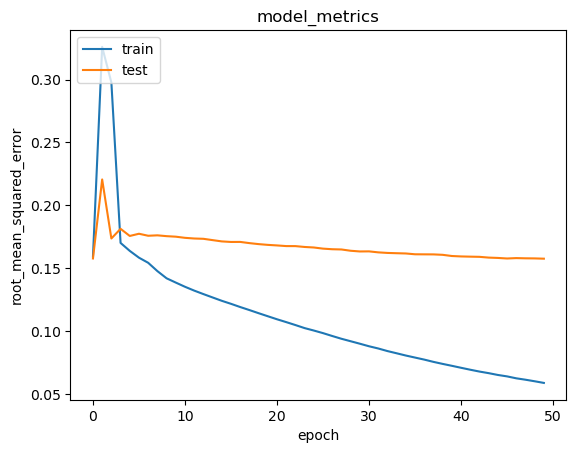

In [47]:
# Plotting the training and validation loss
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:


# Pilih user acak (dalam bentuk string, bukan integer)
user_id = df_cv_first.user.sample(1).iloc[0]
user_watched_movie = df_cv_first[df_cv_first.user == user_id]

# Mendapatkan daftar judul film yang sudah ditonton user_id
watched_titles = set(user_watched_movie['title'])

# Mendapatkan semua judul film yang tersedia
all_titles = set(df_set['title'])

# Mendapatkan judul film yang belum ditonton user_id
movie_not_watched = all_titles - watched_titles

print('Jumlah film yang belum ditonton oleh user {}: {}'.format(user_id, len(movie_not_watched)))

# Mengubah judul film yang belum ditonton menjadi encoded format
movie_not_watched = [[title_to_title_encoded.get(x)] for x in movie_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movie_not_watched), movie_not_watched)
)


Jumlah film yang belum ditonton oleh user o: 34607


In [81]:
# Melakukan prediksi rating untuk film yang belum ditonton oleh user_id
ratings = model.predict(user_movie_array).flatten()
 
# Mengurutkan rating dan mengambil 10 film dengan rating tertinggi
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    title_encoded_to_title.get(movie_not_watched[x][0]) for x in top_ratings_indices
]

# Menampilkan rekomendasi film untuk user_id
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Movie with high ratings from user')
print('----' * 8)
 
top_resto_user = (
    user_watched_movie.sort_values(
        by = 'avg_vote',
        ascending=False
    )
    .head(5)
    .title.values
)

# Menampilkan judul film yang belum ditonton oleh user_id beserta genre-nya
for movie in top_resto_user:
    for genre in df_cv_first[df_cv_first.title == movie].genre:
        print(movie, ':', genre)
        break
 
print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)

# Menampilkan rekomendasi film yang belum ditonton oleh user_id beserta genre-nya
for movie in recommended_movie_ids:
    for genre in df_cv_first[df_cv_first.title == movie].genre:
        print(movie, ':', genre)
        break

1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step
Showing recommendations for users: o
Movie with high ratings from user
--------------------------------
Ladri di biciclette : Drama
Greed : Drama
Dekalog ieden-dziesiec : Drama
Diaries, Sketch and Notes, also known as Walden : Documentary
Le plaisir : Comedy
--------------------------------
Top 10 movie recommendation
--------------------------------
Alien : Sci-Fi
Blade Runner : Sci-Fi
Les Vampires : Adventure
Don Giovanni : Musical
The Exorcist : Horror
Tol'able David : Drama
Star Wars : Sci-Fi
Roma : Grotesque
L'argent : Drama
The Killers : Thriller
